<a href="https://colab.research.google.com/github/chadloh/GoogleDecimeterChallenge/blob/main/GoogleDecimeter_220612_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Decimeter Challenge

##### Chad Loh, Michelle Bui, Layal Hammad, Caroline Keough

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pymap3d pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 613 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 5.1 MB/s 
  Created wheel for pymap3d: filename=pymap3d-2.8.0-py3-none-any.whl size=51474 sha256=2590dab433bedb18106b6f4243c3c54cf71d0a8e5243f0c1fe183f9364cb123d
  Stored in directory: /root/.cache/pip/wheels/ce/e9/6c/1f371a1edf55b46a532795857627394d2134c50358f47244ba
Successfully built pymap3d


In [ ]:
import math
import numpy as np
import pandas as pd
import pymap3d as pm
import pymap3d.vincenty as pmv
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import glob as gl 
import scipy.optimize
from tqdm.auto import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.spatial import distance
from scipy import signal
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pyproj as proj
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)

### Satellite Selection

In [ ]:
# Satellite selection using carrier frequency error, elevation angle, and C/N0
def satellite_selection(df, column):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df[column].notnull()
    idx &= df['CarrierErrorHz'] < 2.0e6         # carrier frequency error (Hz)
    idx &= df['SvElevationDegrees'] > 10.0      # elevation angle (deg)
    idx &= df['Cn0DbHz'] > 15.0                 # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0        # Multipath flag

    return df[idx]

### point_positioning: Robust Weighted Least Squares

In [ ]:
# GNSS single point positioning using pseudorange
def point_positioning(gnss_df):
    # Add nominal frequency to each signal
    # Note: GLONASS is an FDMA signal, so each satellite has a different frequency
    CarrierFrequencyHzRef = gnss_df.groupby(['Svid', 'SignalType'])[
        'CarrierFrequencyHz'].median()
    gnss_df = gnss_df.merge(CarrierFrequencyHzRef, how='left', on=[
                            'Svid', 'SignalType'], suffixes=('', 'Ref'))
    gnss_df['CarrierErrorHz'] = np.abs(
        (gnss_df['CarrierFrequencyHz'] - gnss_df['CarrierFrequencyHzRef']))

    # Carrier smoothing
    gnss_df = carrier_smoothing(gnss_df)

    # GNSS single point positioning
    utcTimeMillis = gnss_df['utcTimeMillis'].unique()
    nepoch = len(utcTimeMillis)
    x0 = np.zeros(4)  # [x,y,z,tGPSL1]
    v0 = np.zeros(4)  # [vx,vy,vz,dtGPSL1]
    x_wls = np.full([nepoch, 3], np.nan)  # For saving position
    v_wls = np.full([nepoch, 3], np.nan)  # For saving velocity

    # Loop for epochs
    for i, (t_utc, df) in enumerate(tqdm(gnss_df.groupby('utcTimeMillis'), total=nepoch)):
        # Valid satellite selection
        df_pr = satellite_selection(df, 'pr_smooth')
        df_prr = satellite_selection(df, 'PseudorangeRateMetersPerSecond')

        # Corrected pseudorange/pseudorange rate
        pr = (df_pr['pr_smooth'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] -
              df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()
        prr = (df_prr['PseudorangeRateMetersPerSecond'] +
               df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Satellite position/velocity
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                         'SvPositionZEcefMeters']].to_numpy()
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                           'SvPositionZEcefMeters']].to_numpy()
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond',
                       'SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Weight matrix for peseudorange/pseudorange rate
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())

        # Robust WLS requires accurate initial values for convergence,
        # so perform normal WLS for the first time
        if len(df_pr) >= 4:
            # Normal WLS
            if np.all(x0 == 0):
                opt = scipy.optimize.least_squares(
                    pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))
                x0 = opt.x 
            # Robust WLS for position estimation
            opt = scipy.optimize.least_squares(
                 pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')
            if opt.status < 1 or opt.status == 2:
                 print(f'i = {i} position lsq status = {opt.status}')
            else:
                 x_wls[i, :] = opt.x[:3]
                 x0 = opt.x
                 
        # Velocity estimation
        if len(df_prr) >= 4:
            if np.all(v0 == 0): # Normal WLS
                opt = scipy.optimize.least_squares(
                    prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x
            # Robust WLS for velocity estimation
            opt = scipy.optimize.least_squares(
                prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:
                print(f'i = {i} velocity lsq status = {opt.status}')
            else:
                v_wls[i, :] = opt.x[:3]
                v0 = opt.x

    return utcTimeMillis, x_wls, v_wls

### Carrier Smoothing

In [ ]:
# Carrier smoothing of pseudarange
def carrier_smoothing(gnss_df):
    """
    Args:
        df : DataFrame from device_gnss.csv
    Returns:
        df: DataFrame with carrier-smoothing pseudorange 'pr_smooth'
    """
    carr_th = 1.6 # carrier phase jump threshold [m] 2->1.5 (best)->1.0
    pr_th =  20.0 # pseudorange jump threshold [m] 20->15

    prsmooth = np.full_like(gnss_df['RawPseudorangeMeters'], np.nan)
    # Loop for each signal
    for (i, (svid_sigtype, df)) in enumerate((gnss_df.groupby(['Svid', 'SignalType']))):
        df = df.replace(
            {'AccumulatedDeltaRangeMeters': {0: np.nan}})  # 0 to NaN

        # Compare time difference between pseudorange/carrier with Doppler
        drng1 = df['AccumulatedDeltaRangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']
        drng2 = df['RawPseudorangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']

        # Check cycle-slip
        slip1 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**1) != 0  # reset flag
        slip2 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**2) != 0  # cycle-slip flag
        slip3 = np.fabs(drng1.to_numpy()) > carr_th # Carrier phase jump
        slip4 = np.fabs(drng2.to_numpy()) > pr_th # Pseudorange jump

        idx_slip = slip1 | slip2 | slip3 | slip4
        idx_slip[0] = True

        # groups with continuous carrier phase tracking
        df['group_slip'] = np.cumsum(idx_slip)

        # Psudorange - carrier phase
        df['dpc'] = df['RawPseudorangeMeters'] - df['AccumulatedDeltaRangeMeters']

        # Absolute distance bias of carrier phase
        meandpc = df.groupby('group_slip')['dpc'].mean()
        df = df.merge(meandpc, on='group_slip', suffixes=('', '_Mean'))

        # Index of original gnss_df
        idx = (gnss_df['Svid'] == svid_sigtype[0]) & (
            gnss_df['SignalType'] == svid_sigtype[1])

        # Carrier phase + bias
        prsmooth[idx] = df['AccumulatedDeltaRangeMeters'] + df['dpc_Mean']

    # If carrier smoothing is not possible, use original pseudorange
    idx_nan = np.isnan(prsmooth)
    prsmooth[idx_nan] = gnss_df['RawPseudorangeMeters'][idx_nan]
    gnss_df['pr_smooth'] = prsmooth

    return gnss_df

### Pseudorange/Doppler Residuals and Jacobian

In [ ]:
# Compute line-of-sight vector from user to satellite
def los_vector(xusr, xsat):
    """
    Args:
        xusr : user position in ECEF (m)
        xsat : satellite position in ECEF (m)
    Returns:
        u: unit line-of-sight vector in ECEF (m)
        rng: distance between user and satellite (m)
    """
    u = xsat - xusr
    rng = np.linalg.norm(u, axis=1).reshape(-1, 1)
    u /= rng
    
    return u, rng.reshape(-1)


# Compute Jacobian matrix
def jac_pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(pr), 1])])  # J = [-ux -uy -uz 1]

    return W @ J


# Compute pseudorange residuals
def pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange residuals
    """
    u, rng = los_vector(x[:3], xsat)

    # Approximate correction of the earth rotation (Sagnac effect) often used in GNSS positioning
    rng += OMGE * (xsat[:, 0] * x[1] - xsat[:, 1] * x[0]) / CLIGHT

    # Add GPS L1 clock offset
    residuals = rng - (pr - x[3])

    return residuals @ W


# Compute Jacobian matrix
def jac_prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(prr), 1])])

    return np.dot(W, J)


# Compute pseudorange rate residuals
def prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange rate residuals
    """
    u, rng = los_vector(x[:3], xsat)
    rate = np.sum((vsat-v[:3])*u, axis=1) \
          + OMGE / CLIGHT * (vsat[:, 1] * x[0] + xsat[:, 1] * v[0]
                           - vsat[:, 0] * x[1] - xsat[:, 0] * v[1])

    residuals = rate - (prr - v[3])

    return residuals @ W

### Outlier Detection and Interpolation

In [ ]:
# Simple outlier detection and interpolation
def exclude_interpolate_outlier(x_wls, v_wls):
    # Up velocity threshold
    v_up_th = 2.0 # m/s

    # Coordinate conversion
    x_llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
    v_enu = np.array(pm.ecef2enuv(
        v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], x_llh[0, 0], x_llh[0, 1])).T

    # Up velocity jump detection
    # Cars don't jump suddenly!
    idx_v_out = np.abs(v_enu[:, 2]) > v_up_th
    v_wls[idx_v_out, :] = np.nan
    
    # Interpolate NaNs at beginning and end of array
    x_df = pd.DataFrame({'x': x_wls[:, 0], 'y': x_wls[:, 1], 'z': x_wls[:, 2]})
    x_df = x_df.interpolate(limit_area='outside', limit_direction='both')
    
    # Interpolate all NaN data
    v_df = pd.DataFrame({'x': v_wls[:, 0], 'y': v_wls[:, 1], 'z': v_wls[:, 2]})
    v_df = v_df.interpolate(limit_area='outside', limit_direction='both')
    v_df = v_df.interpolate('spline', order=3)

    return x_df.to_numpy(), v_df.to_numpy()

### Kalman Smoother

In [ ]:
# Kalman filter
def Kalman_filter(zs, us, phone):
    # Parameters
    # I don't know why only XiaomiMi8 seems to be inaccurate ... 
    sigma_v = 0.6 if phone == 'XiaomiMi8' else 0.1 # velocity SD m/s
    sigma_x = 5.0  # position SD m
    sigma_mahalanobis = 30.0 # Mahalanobis distance for rejecting innovation
    
    n, dim_x = zs.shape
    F = np.eye(3)  # Transition matrix
    Q = sigma_v**2 * np.eye(3)  # Process noise

    H = np.eye(3)  # Measurement function
    R = sigma_x**2 * np.eye(3)  # Measurement noise

    # Initial state and covariance
    x = zs[0, :3].T  # State
    P = sigma_x**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    # Kalman filtering
    for i, (u, z) in enumerate(zip(us, zs)):
        # First step
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            continue

        # Prediction step
        x = F @ x + u.T
        P = (F @ P) @ F.T + Q

        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.pinv(P))

        # Update step
        if d < sigma_mahalanobis:
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
        else:
            # If no observation update is available, increase covariance
            P += 10**2*Q

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf


# Forward + backward Kalman filter and smoothing
def Kalman_smoothing(x_wls, v_wls, phone):
    n, dim_x = x_wls.shape

    # Forward
    v = np.vstack([np.zeros([1, 3]), (v_wls[:-1, :] + v_wls[1:, :])/2])
    x_f, P_f = Kalman_filter(x_wls, v, phone)

    # Backward
    v = -np.flipud(v_wls)
    v = np.vstack([np.zeros([1, 3]), (v[:-1, :] + v[1:, :])/2])
    x_b, P_b = Kalman_filter(np.flipud(x_wls), v, phone)

    # Smoothing
    x_fb = np.zeros_like(x_f)
    P_fb = np.zeros_like(P_f)
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])
        P_bi = np.linalg.inv(P_b[b])

        P_fb[f] = np.linalg.inv(P_fi + P_bi)
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b])

    return x_fb, x_f, np.flipud(x_b)

### Adding new features

In [ ]:
def convert_wgs_to_utm(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

def add_features(df):
    # setup your projections
    utm_code = convert_wgs_to_utm(df['lon'].mean(), df['lat'].mean())
    crs_wgs = proj.Proj(init='epsg:4326') # assuming using WGS84
    crs_utm = proj.Proj(init='epsg:{0}'.format(utm_code))
    x, y = np.multiply(proj.transform(crs_wgs, crs_utm, df['lon'], df['lat']),0.001)

    # Velocity and Speed
    x_t = np.gradient(x)
    y_t = np.gradient(y)

    vel = np.array([ [x_t[i], y_t[i]] for i in range(x_t.size)])
    
    speed = np.sqrt(x_t * x_t + y_t * y_t)
    
    tangent = np.array([1/speed] * 2).transpose() * vel

    # Curvature
    ss_t = np.gradient(speed)
    xx_t = np.gradient(x_t)
    yy_t = np.gradient(y_t)
    curvature = (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
    xxyy = np.sqrt(xx_t * xx_t + yy_t * yy_t)
    
    # Accelaration
    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt] * 2).transpose() * dT_dt

    t_component = np.array([ss_t] * 2).transpose()
    n_component = np.array([curvature*ss_t * ss_t] * 2).transpose()
    accel = t_component * tangent + n_component * normal
    
    curvature[curvature>10]=5
    curvature[curvature<-10]=-5
    curvature = signal.medfilt(1/(1+np.exp(-signal.medfilt(curvature,3))),7)
    df['curve']= curvature
    df['speed']= signal.medfilt(speed,3)
    df['acc'] = signal.medfilt(np.linalg.norm(accel, axis=1),3)
    df['gas']= signal.medfilt(ss_t,3)
    df['dir_x'] = x_t / speed
    df['dir_y'] = y_t / speed
    # df['dir_x_t'] = xx_t / xxyy
    # df['dir_y_t'] = yy_t / xxyy
  
    return df

### Scoring

In [ ]:
# Compute distance by Vincenty's formulae
def vincenty_distance(llh1, llh2):
    """
    Args:
        llh1 : [latitude,longitude] (deg)
        llh2 : [latitude,longitude] (deg)
    Returns:
        d : distance between llh1 and llh2 (m)
    """
    d, az = np.array(pmv.vdist(llh1[:, 0], llh1[:, 1], llh2[:, 0], llh2[:, 1]))

    return d


# Compute score
def calc_score(llh, llh_gt):
    """
    Args:
        llh : [latitude,longitude] (deg)
        llh_gt : [latitude,longitude] (deg)
    Returns:
        score : (m)
    """
    d = vincenty_distance(llh, llh_gt)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])

    return score

### Train data and Score Computation

In [ ]:
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'

drive, phone = path.split('/')[-2:]

# Read data
gnss_df = pd.read_csv(f'{path}/device_gnss.csv')  # GNSS data
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth

# Point positioning
utc, x_wls, v_wls = point_positioning(gnss_df)

# Exclude velocity outliers
x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

# Kalman smoothing
x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

# Convert to latitude and longitude
llh_wls = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

# Baseline
x_bl = gnss_df.groupby('TimeNanos')[
    ['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].mean().to_numpy()
llh_bl = np.array(pm.ecef2geodetic(x_bl[:, 0], x_bl[:, 1], x_bl[:, 2])).T

# Ground truth
llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

# Distance from ground truth
vd_bl = vincenty_distance(llh_bl, llh_gt)
vd_wls = vincenty_distance(llh_wls, llh_gt)
vd_kf = vincenty_distance(llh_kf, llh_gt)

# Score
score_bl = calc_score(llh_bl, llh_gt)
score_wls = calc_score(llh_wls, llh_gt)
score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')

  0%|          | 0/1896 [00:00<?, ?it/s]

Score Baseline   2.1929 [m]
Score Robust WLS 1.9769 [m]
Score KF         1.1443 [m]


### Plotting

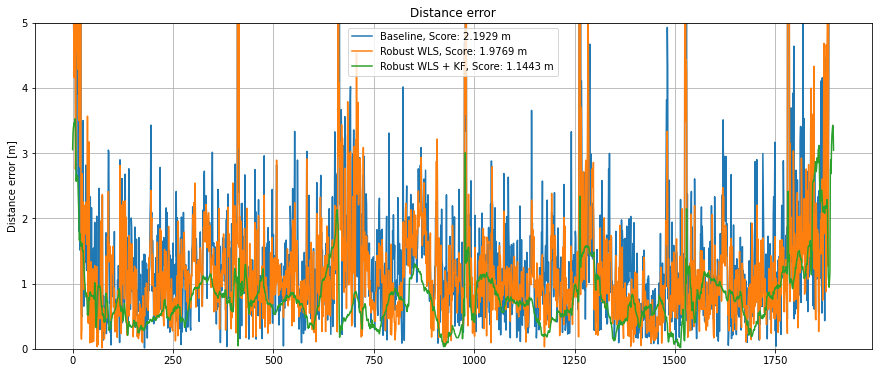

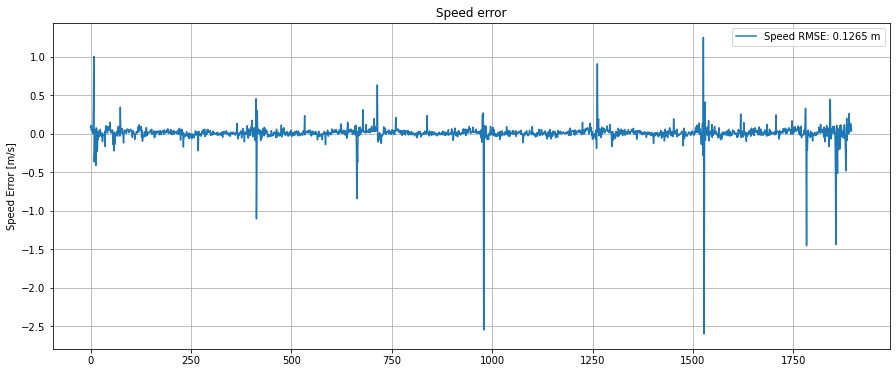

In [ ]:
# Plot distance error
plt.figure(figsize=(15,6))
plt.title('Distance error')
plt.ylabel('Distance error [m]')
plt.plot(vd_bl, label=f'Baseline, Score: {score_bl:.4f} m')
plt.plot(vd_wls, label=f'Robust WLS, Score: {score_wls:.4f} m')
plt.plot(vd_kf, label=f'Robust WLS + KF, Score: {score_kf:.4f} m')
plt.legend()
plt.grid()
plt.ylim([0, 5])

# Compute velocity error
speed_wls = np.linalg.norm(v_wls[:, :3], axis=1)
speed_gt = gt_df['SpeedMps'].to_numpy()
speed_rmse = np.sqrt(np.sum((speed_wls-speed_gt)**2)/len(speed_gt))

# Plot velocity error
plt.figure(figsize=(15,6))
plt.title('Speed error')
plt.ylabel('Speed Error [m/s]')
plt.plot(speed_wls - speed_gt, label=f'Speed RMSE: {speed_rmse:.4f} m')
plt.legend()
plt.grid()

### Mapping

In [ ]:
llh_bl_df = pd.DataFrame(llh_bl, columns = ['lat', 'lon', 'Noise'])
llh_wls_df = pd.DataFrame(llh_wls, columns = ['lat', 'lon', 'Noise'])
llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])

gt_df.rename(columns = {'LatitudeDegrees':'lat', 'LongitudeDegrees':'lon'}, inplace = True)

all_tracks = pd.concat([gt_df, llh_bl_df, llh_wls_df, llh_kf_df])
all_tracks  =all_tracks[['lat', 'lon']]
all_tracks['Name'] = np.repeat(['gt','bl', 'wls','kf'],gt_df.shape[0])

fig = px.line_mapbox(all_tracks, lat="lat", lon="lon",
                        color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig = px.line_mapbox(all_tracks, lat="lat", lon="lon",
                        color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [ ]:
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'
llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])
llh_kf_df.to_csv(f'{path}/llh_kf_df.csv', index=False)\

In [ ]:
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'
llh_kf_df = pd.read_csv(f'{path}/llh_kf_df.csv')
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth
llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

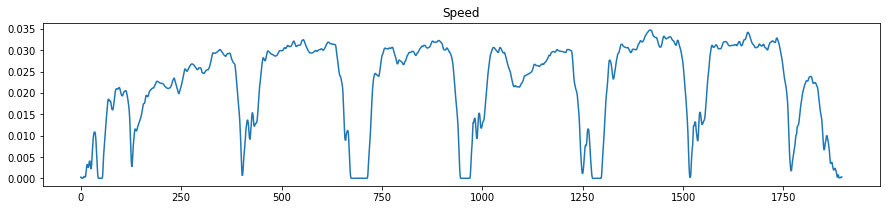

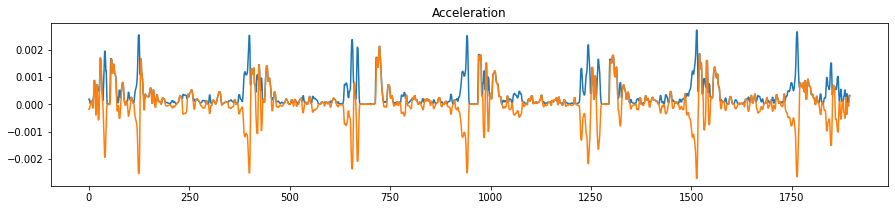

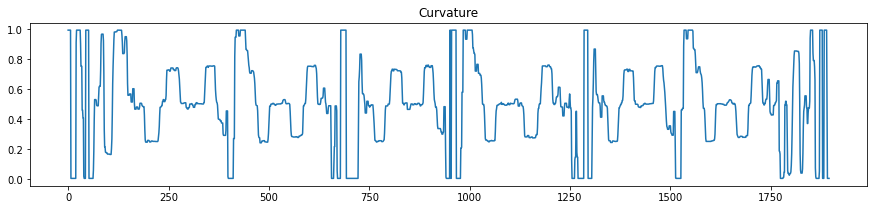

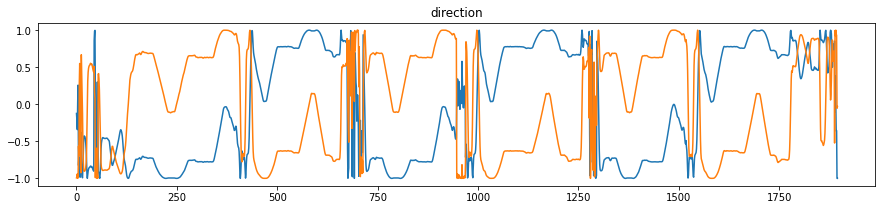

In [ ]:
llh_kf_df = add_features(llh_kf_df)

plt.figure(1, figsize=(15,3))
plt.title("Speed")
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['speed'])

plt.figure(2, figsize=(15,3))
plt.title("Acceleration")
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['acc'])
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['gas'])

plt.figure(3, figsize=(15,3))
plt.title("Curvature")
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['curve'])

plt.figure(4, figsize=(15,3))
plt.title("direction")
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['dir_x'])
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['dir_y'])

# plt.figure(11, figsize=(15,3))
# plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['dir_x_t'])
# plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['dir_y_t'])

In [ ]:
fig = px.scatter_mapbox(llh_kf_df,lat="lat", lon="lon", color="curve",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

### Preparation for ML

In [ ]:
llh_kf_df.iloc[:,2:]

,Noise,curve,speed,acc,gas,dir_x,dir_y
0,2.854154,0.993307,0.000268,0.000186,-0.000186,-0.124491,-0.992221
1,3.414005,0.993307,0.000268,0.000186,-0.000186,-0.214177,-0.976795
2,3.724670,0.993307,0.000083,0.000096,-0.000095,-0.341366,-0.939930
3,3.659461,0.993307,0.000077,0.000032,-0.000032,0.035753,-0.999361
4,3.780984,0.993307,0.000028,0.000032,-0.000025,0.258751,-0.965944
...,...,...,...,...,...,...,...
1891,-10.682220,0.006693,0.000171,0.000064,-0.000063,-0.022588,0.999745
1892,-10.348774,0.006693,0.000166,0.000076,-0.000063,-0.360195,0.932877
1893,-11.146979,0.006693,0.000166,0.000312,0.000092,-0.355602,0.934638
1894,-11.049652,0.006693,0.000350,0.000331,0.000318,-0.998558,-0.053683


In [ ]:
sc = MinMaxScaler(feature_range=(-1,1))

window_size = 8
x_window = llh_kf_df.iloc[:,3:]
for i in range(1,window_size):
  x_window = pd.concat([x_window, llh_kf_df.iloc[:,3:].shift(i)], axis = 1)
x_window = x_window.fillna(method = 'backfill')

x_data = np.array(x_window)
y_data = llh_gt
new_x_data = sc.fit_transform(x_data)
new_y_data = (y_data-np.array(llh_kf_df.iloc[:,0:2]))*1e5


# new_x_data = new_x_data.reshape(new_x_data.shape[0],new_x_data.shape[1],1)

print('X_data shape :', x_data.shape)
print('new X_data shape :', new_x_data.shape)
print('y_data shape :', y_data.shape)
print('new y_data shape :', new_y_data.shape)

X_data shape : (1896, 48)
new X_data shape : (1896, 48)
y_data shape : (1896, 2)
new y_data shape : (1896, 2)


In [ ]:
model = Sequential()

# model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

history = model.fit(new_x_data,new_y_data,epochs=100, verbose=2)
          

Epoch 1/100
60/60 - 1s - loss: 0.3112 - accuracy: 0.6276
Epoch 2/100
60/60 - 0s - loss: 0.2426 - accuracy: 0.6714
Epoch 3/100
60/60 - 0s - loss: 0.2166 - accuracy: 0.6973
Epoch 4/100
60/60 - 0s - loss: 0.1999 - accuracy: 0.7068
Epoch 5/100
60/60 - 0s - loss: 0.1898 - accuracy: 0.7104
Epoch 6/100
60/60 - 0s - loss: 0.1820 - accuracy: 0.7009
Epoch 7/100
60/60 - 0s - loss: 0.1753 - accuracy: 0.7073
Epoch 8/100
60/60 - 0s - loss: 0.1695 - accuracy: 0.7015
Epoch 9/100
60/60 - 0s - loss: 0.1645 - accuracy: 0.7115
Epoch 10/100
60/60 - 0s - loss: 0.1580 - accuracy: 0.7226
Epoch 11/100
60/60 - 0s - loss: 0.1512 - accuracy: 0.7141
Epoch 12/100
60/60 - 0s - loss: 0.1470 - accuracy: 0.7284
Epoch 13/100
60/60 - 0s - loss: 0.1454 - accuracy: 0.7300
Epoch 14/100
60/60 - 0s - loss: 0.1378 - accuracy: 0.7310
Epoch 15/100
60/60 - 0s - loss: 0.1320 - accuracy: 0.7363
Epoch 16/100
60/60 - 0s - loss: 0.1281 - accuracy: 0.7405
Epoch 17/100
60/60 - 0s - loss: 0.1258 - accuracy: 0.7405
Epoch 18/100
60/60 - 0s

In [ ]:
model = Sequential()

model.add(LSTM(units=64, batch_input_shape=(None,new_x_data.shape[1],1),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=32,return_sequences=False))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(2))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.summary()
          

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 1, 64)             16896     
_________________________________________________________________
lstm_43 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_72 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_73 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_74 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_75 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_76 (Dense)             (None, 2)               

### Model

In [ ]:
history = model.fit(new_x_data,new_y_data,epochs=50, verbose=2)

Epoch 1/50
60/60 - 7s - loss: 0.4153 - accuracy: 0.6487
Epoch 2/50
60/60 - 0s - loss: 0.3316 - accuracy: 0.6551
Epoch 3/50
60/60 - 0s - loss: 0.3108 - accuracy: 0.6551
Epoch 4/50
60/60 - 0s - loss: 0.3099 - accuracy: 0.6551
Epoch 5/50
60/60 - 0s - loss: 0.3102 - accuracy: 0.6551
Epoch 6/50
60/60 - 0s - loss: 0.3099 - accuracy: 0.6551
Epoch 7/50
60/60 - 0s - loss: 0.3098 - accuracy: 0.6551
Epoch 8/50
60/60 - 0s - loss: 0.3089 - accuracy: 0.6551
Epoch 9/50
60/60 - 0s - loss: 0.3071 - accuracy: 0.6551
Epoch 10/50
60/60 - 0s - loss: 0.3074 - accuracy: 0.6551
Epoch 11/50
60/60 - 0s - loss: 0.3066 - accuracy: 0.6551
Epoch 12/50
60/60 - 0s - loss: 0.3069 - accuracy: 0.6551
Epoch 13/50
60/60 - 0s - loss: 0.3067 - accuracy: 0.6551
Epoch 14/50
60/60 - 0s - loss: 0.3066 - accuracy: 0.6551
Epoch 15/50
60/60 - 0s - loss: 0.3100 - accuracy: 0.6482
Epoch 16/50
60/60 - 0s - loss: 0.3054 - accuracy: 0.6551
Epoch 17/50
60/60 - 0s - loss: 0.3077 - accuracy: 0.6498
Epoch 18/50
60/60 - 0s - loss: 0.3049 - 

In [ ]:
model.save('/content/drive/MyDrive/Google_decimeter/model_0611.h5')
from tensorflow.python.keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Google_decimeter/model_0611.h5')

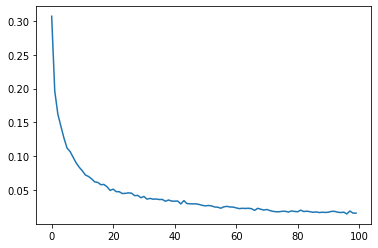

In [ ]:
plt.plot(history.history['loss'])
plt.show()

In [ ]:
gt_df

,MessageType,Provider,LatitudeDegrees,LongitudeDegrees,AltitudeMeters,SpeedMps,AccuracyMeters,BearingDegrees,UnixTimeMillis
0,Fix,GT,37.444105,-122.232767,10.852000,0.001000,0.1,30.257385,1626727759438
1,Fix,GT,37.444105,-122.232767,10.851000,0.001000,0.1,30.257416,1626727760438
2,Fix,GT,37.444106,-122.232767,10.851000,0.001414,0.1,30.257507,1626727761438
3,Fix,GT,37.444106,-122.232767,10.851000,0.001414,0.1,30.257446,1626727762438
4,Fix,GT,37.444106,-122.232767,10.851000,0.001414,0.1,30.257294,1626727763438
...,...,...,...,...,...,...,...,...,...
1891,Fix,GT,37.444102,-122.232774,11.294000,0.011045,0.1,31.762573,1626729650438
1892,Fix,GT,37.444102,-122.232774,11.298388,0.010050,0.1,31.762634,1626729651438
1893,Fix,GT,37.444103,-122.232774,11.300000,0.009055,0.1,31.762573,1626729652438
1894,Fix,GT,37.444103,-122.232774,11.300000,0.008645,0.1,31.762390,1626729653438


In [ ]:
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth
gt_df[['lat', 'lon']] = gt_df[['LatitudeDegrees', 'LongitudeDegrees']]
res_df = (model.predict(new_x_data))/1e5 + np.array(llh_kf_df.iloc[:,0:2])

# Distance from ground truth
vd_nn = vincenty_distance(res_df, llh_gt)

# Score
score_nn = calc_score(res_df[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')
print(f'Score NN         {score_nn:.4f} [m]')

llh_nn_df = pd.DataFrame(res_df, columns = ['lat', 'lon'])

all_tracks = pd.concat([gt_df, llh_bl_df, llh_wls_df, llh_kf_df, llh_nn_df])
all_tracks  =all_tracks[['lat', 'lon']]
all_tracks['Name'] = np.repeat(['gt','bl', 'wls','kf', 'nn'],gt_df.shape[0])

fig = px.line_mapbox(all_tracks, lat="lat", lon="lon",
                        color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig = px.line_mapbox(all_tracks, lat="lat", lon="lon",
                        color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

Score Baseline   2.1929 [m]
Score Robust WLS 1.9769 [m]
Score KF         3.2019 [m]
Score NN         0.3939 [m]


### Validation

In [ ]:
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/'
cnt = 1
# Loop for each trip
for i, dirname in enumerate(tqdm(sorted(gl.glob(f'{path}/train/*/*/')))):
  # if cnt == 2:
  #   break
  drive, phone = dirname.split('/')[-3:-1]
  tripID = f'{drive}/{phone}'
  print(tripID)

  # Read data
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
  gt_df = pd.read_csv(f'{dirname}/ground_truth.csv')  # ground truth

  # Point positioning
  utc, x_wls, v_wls = point_positioning(gnss_df)

  # Exclude velocity outliers
  x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

  # Kalman smoothing
  x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

  # Convert to latitude and longitude
  llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

  # Save df
  llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])
  llh_kf_df.to_csv(f'{dirname}/llh_kf_df.csv', index=False)

  # Add features
  llh_kf_df = add_features(llh_kf_df)

  x_data = np.array(llh_kf_df)
  y_data = np.array(gt_df[['LatitudeDegrees', 'LongitudeDegrees']])
  test_x_data = sc.fit_transform(x_data[:,2:])
  test_x_data = test_x_data.reshape(test_x_data.shape[0],test_x_data.shape[1],1)
  res_df = (model.predict(test_x_data))/1e5 + x_data[:,0:2]

  # Ground truth
  llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

  # Distance from ground truth
  vd_kf = vincenty_distance(llh_kf, llh_gt)

  # Score
  score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])

  # Distance from ground truth
  vd_nn = vincenty_distance(res_df, llh_gt)

  # Score
  score_nn = calc_score(res_df[:-1, :], llh_gt[:-1, :])

  print(f'Score KF         {score_kf:.4f} [m]')
  print(f'Score NN         {score_nn:.4f} [m]')
  

  cnt = cnt+1

  0%|          | 0/170 [00:00<?, ?it/s]

2020-05-15-US-MTV-1/GooglePixel4XL


  0%|          | 0/3362 [00:00<?, ?it/s]

Score KF         3.3149 [m]
Score NN         4.1079 [m]
2020-05-21-US-MTV-1/GooglePixel4


  0%|          | 0/1952 [00:00<?, ?it/s]

Score KF         2.8871 [m]
Score NN         2.7775 [m]
2020-05-21-US-MTV-1/GooglePixel4XL


  0%|          | 0/1947 [00:00<?, ?it/s]

Score KF         1.7439 [m]
Score NN         1.7205 [m]
2020-05-21-US-MTV-2/GooglePixel4


  0%|          | 0/1889 [00:00<?, ?it/s]

Score KF         1.1556 [m]
Score NN         2.1748 [m]
2020-05-21-US-MTV-2/GooglePixel4XL


  0%|          | 0/1895 [00:00<?, ?it/s]

Score KF         1.5868 [m]
Score NN         2.4111 [m]
2020-05-28-US-MTV-2/GooglePixel4


  0%|          | 0/2212 [00:00<?, ?it/s]

Score KF         1.5359 [m]
Score NN         2.8434 [m]
2020-05-28-US-MTV-2/GooglePixel4XL


  0%|          | 0/2208 [00:00<?, ?it/s]

Score KF         1.0372 [m]
Score NN         2.3228 [m]
2020-05-29-US-MTV-1/GooglePixel4


  0%|          | 0/1879 [00:00<?, ?it/s]

i = 761 position lsq status = 2
i = 779 position lsq status = 2
Score KF         1.9920 [m]
Score NN         1.8820 [m]
2020-05-29-US-MTV-1/GooglePixel4XL


  0%|          | 0/1879 [00:00<?, ?it/s]

Score KF         2.0580 [m]
Score NN         1.7777 [m]
2020-05-29-US-MTV-2/GooglePixel4


  0%|          | 0/1964 [00:00<?, ?it/s]

i = 1122 position lsq status = 0
Score KF         2.2211 [m]
Score NN         2.1904 [m]
2020-05-29-US-MTV-2/GooglePixel4XL


  0%|          | 0/1969 [00:00<?, ?it/s]

Score KF         2.3208 [m]
Score NN         2.0673 [m]
2020-06-04-US-MTV-1/GooglePixel4


  0%|          | 0/1655 [00:00<?, ?it/s]

Score KF         1.9706 [m]
Score NN         1.6830 [m]
2020-06-04-US-MTV-1/GooglePixel4XL


  0%|          | 0/1657 [00:00<?, ?it/s]

Score KF         1.1982 [m]
Score NN         1.1863 [m]
2020-06-04-US-MTV-2/GooglePixel4


  0%|          | 0/1650 [00:00<?, ?it/s]

Score KF         2.3230 [m]
Score NN         2.3034 [m]
2020-06-04-US-MTV-2/GooglePixel4XL


  0%|          | 0/1648 [00:00<?, ?it/s]

Score KF         2.2096 [m]
Score NN         2.3238 [m]
2020-06-05-US-MTV-1/GooglePixel4


  0%|          | 0/1843 [00:00<?, ?it/s]

Score KF         1.0709 [m]
Score NN         1.6443 [m]
2020-06-05-US-MTV-1/GooglePixel4XL


  0%|          | 0/1897 [00:00<?, ?it/s]

Score KF         2.1026 [m]
Score NN         2.5676 [m]
2020-06-05-US-MTV-2/GooglePixel4


  0%|          | 0/1682 [00:00<?, ?it/s]

Score KF         1.2686 [m]
Score NN         1.7925 [m]
2020-06-05-US-MTV-2/GooglePixel4XL


  0%|          | 0/1628 [00:00<?, ?it/s]

Score KF         1.2680 [m]
Score NN         1.5545 [m]
2020-06-10-US-MTV-1/GooglePixel4


  0%|          | 0/1601 [00:00<?, ?it/s]

Score KF         1.4323 [m]
Score NN         1.3658 [m]
2020-06-10-US-MTV-1/GooglePixel4XL


  0%|          | 0/1599 [00:00<?, ?it/s]

Score KF         1.6103 [m]
Score NN         1.4140 [m]
2020-06-10-US-MTV-2/GooglePixel4


  0%|          | 0/1753 [00:00<?, ?it/s]

Score KF         1.8804 [m]
Score NN         2.7285 [m]
2020-06-10-US-MTV-2/GooglePixel4XL


  0%|          | 0/1754 [00:00<?, ?it/s]

Score KF         1.6505 [m]
Score NN         3.0146 [m]
2020-06-11-US-MTV-1/GooglePixel4


  0%|          | 0/1848 [00:00<?, ?it/s]

Score KF         1.1751 [m]
Score NN         1.4691 [m]
2020-06-11-US-MTV-1/GooglePixel4XL


  0%|          | 0/1842 [00:00<?, ?it/s]

Score KF         0.9494 [m]
Score NN         1.0722 [m]
2020-06-18-US-MTV-1/GooglePixel4


  0%|          | 0/1463 [00:00<?, ?it/s]

Score KF         2.1268 [m]
Score NN         1.9679 [m]
2020-06-18-US-MTV-1/GooglePixel4XL


  0%|          | 0/1459 [00:00<?, ?it/s]

Score KF         1.5479 [m]
Score NN         1.2713 [m]
2020-06-24-US-MTV-1/GooglePixel4


  0%|          | 0/1299 [00:00<?, ?it/s]

Score KF         1.9096 [m]
Score NN         1.8769 [m]
2020-06-24-US-MTV-1/GooglePixel4XL


  0%|          | 0/1302 [00:00<?, ?it/s]

Score KF         1.4489 [m]
Score NN         1.5814 [m]
2020-06-24-US-MTV-2/GooglePixel4


  0%|          | 0/1349 [00:00<?, ?it/s]

Score KF         2.0804 [m]
Score NN         2.8601 [m]
2020-06-24-US-MTV-2/GooglePixel4XL


  0%|          | 0/1344 [00:00<?, ?it/s]

Score KF         1.5279 [m]
Score NN         2.2402 [m]
2020-07-08-US-MTV-1/GooglePixel4


  0%|          | 0/2130 [00:00<?, ?it/s]

Score KF         1.4419 [m]
Score NN         1.5340 [m]
2020-07-08-US-MTV-1/GooglePixel4XL


  0%|          | 0/2146 [00:00<?, ?it/s]

Score KF         2.1550 [m]
Score NN         2.3152 [m]
2020-07-08-US-MTV-2/GooglePixel4


  0%|          | 0/2119 [00:00<?, ?it/s]

Score KF         23.8524 [m]
Score NN         23.7244 [m]
2020-07-08-US-MTV-2/GooglePixel4XL


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.



  0%|          | 0/2116 [00:00<?, ?it/s]

Score KF         10.0870 [m]
Score NN         10.4785 [m]
2020-07-17-US-MTV-2/GooglePixel4


  0%|          | 0/1697 [00:00<?, ?it/s]

Score KF         1.1877 [m]
Score NN         1.4598 [m]
2020-07-17-US-MTV-2/GooglePixel4XL


  0%|          | 0/1698 [00:00<?, ?it/s]

Score KF         2.1448 [m]
Score NN         1.9928 [m]
2020-07-24-US-MTV-1/GooglePixel4


  0%|          | 0/2059 [00:00<?, ?it/s]

Score KF         1.8790 [m]
Score NN         1.6439 [m]
2020-07-24-US-MTV-1/GooglePixel4XL


  0%|          | 0/2050 [00:00<?, ?it/s]

Score KF         1.9039 [m]
Score NN         2.1761 [m]
2020-07-24-US-MTV-1/GooglePixel5


  0%|          | 0/2059 [00:00<?, ?it/s]

Score KF         1.5971 [m]
Score NN         1.2904 [m]
2020-07-24-US-MTV-2/GooglePixel4


  0%|          | 0/1868 [00:00<?, ?it/s]

Score KF         1.4082 [m]
Score NN         1.7333 [m]
2020-07-24-US-MTV-2/GooglePixel4XL


  0%|          | 0/1842 [00:00<?, ?it/s]

Score KF         2.3203 [m]
Score NN         2.6547 [m]
2020-07-24-US-MTV-2/GooglePixel5


  0%|          | 0/1894 [00:00<?, ?it/s]

Score KF         2.0906 [m]
Score NN         1.6895 [m]
2020-08-03-US-MTV-1/GooglePixel4


  0%|          | 0/1691 [00:00<?, ?it/s]

Score KF         2.2467 [m]
Score NN         2.5815 [m]
2020-08-03-US-MTV-1/GooglePixel4XL


  0%|          | 0/1690 [00:00<?, ?it/s]

Score KF         2.0478 [m]
Score NN         2.3042 [m]
2020-08-03-US-MTV-2/GooglePixel4


  0%|          | 0/1690 [00:00<?, ?it/s]

Score KF         2.9865 [m]
Score NN         2.9196 [m]
2020-08-03-US-MTV-2/GooglePixel4XL


  0%|          | 0/1628 [00:00<?, ?it/s]

Score KF         2.4164 [m]
Score NN         3.0755 [m]
2020-08-03-US-MTV-2/GooglePixel5


  0%|          | 0/1627 [00:00<?, ?it/s]

i = 1170 position lsq status = 2
Score KF         3.5694 [m]
Score NN         3.5166 [m]
2020-08-06-US-MTV-1/GooglePixel4


  0%|          | 0/1789 [00:00<?, ?it/s]

Score KF         5.5232 [m]
Score NN         5.5270 [m]
2020-08-06-US-MTV-1/GooglePixel4XL


  0%|          | 0/1781 [00:00<?, ?it/s]

Score KF         5.2723 [m]
Score NN         5.3745 [m]
2020-08-06-US-MTV-2/GooglePixel4


  0%|          | 0/1702 [00:00<?, ?it/s]

Score KF         5.3893 [m]
Score NN         5.1675 [m]
2020-08-06-US-MTV-2/GooglePixel4XL


  0%|          | 0/1703 [00:00<?, ?it/s]

Score KF         5.5189 [m]
Score NN         5.2170 [m]
2020-08-06-US-MTV-2/GooglePixel5


  0%|          | 0/1701 [00:00<?, ?it/s]

Score KF         5.3951 [m]
Score NN         5.2061 [m]
2020-08-11-US-MTV-1/GooglePixel4


  0%|          | 0/1749 [00:00<?, ?it/s]

i = 959 position lsq status = 0
i = 960 position lsq status = 0
i = 961 position lsq status = 0
i = 962 position lsq status = 0
i = 963 position lsq status = 0
i = 964 position lsq status = 0
i = 965 position lsq status = 0
i = 966 position lsq status = 0
Score KF         8.0162 [m]
Score NN         8.0324 [m]
2020-08-11-US-MTV-2/GooglePixel4


  0%|          | 0/1630 [00:00<?, ?it/s]

Score KF         2.7046 [m]
Score NN         3.4718 [m]
2020-08-11-US-MTV-2/GooglePixel4XL


  0%|          | 0/1629 [00:00<?, ?it/s]

Score KF         2.8342 [m]
Score NN         3.3142 [m]
2020-08-13-US-MTV-1/GooglePixel4


  0%|          | 0/1880 [00:00<?, ?it/s]

Score KF         2.2687 [m]
Score NN         2.6595 [m]
2020-08-13-US-MTV-1/GooglePixel4XL


  0%|          | 0/1868 [00:00<?, ?it/s]

Score KF         1.6942 [m]
Score NN         1.7985 [m]
2020-08-13-US-MTV-1/GooglePixel5


  0%|          | 0/1829 [00:00<?, ?it/s]

Score KF         2.5799 [m]
Score NN         2.7140 [m]
2020-09-04-US-MTV-1/GooglePixel4


  0%|          | 0/1648 [00:00<?, ?it/s]

Score KF         3.3911 [m]
Score NN         3.5903 [m]
2020-09-04-US-MTV-1/GooglePixel4XL


  0%|          | 0/1655 [00:00<?, ?it/s]

Score KF         1.3718 [m]
Score NN         1.0086 [m]
2020-09-04-US-MTV-2/GooglePixel4


  0%|          | 0/2436 [00:00<?, ?it/s]

Score KF         1.2937 [m]
Score NN         1.6135 [m]
2020-09-04-US-MTV-2/GooglePixel4XL


  0%|          | 0/2435 [00:00<?, ?it/s]

Score KF         1.3511 [m]
Score NN         1.8504 [m]
2020-11-23-US-MTV-1/XiaomiMi8


  0%|          | 0/745 [00:00<?, ?it/s]

Score KF         4.3195 [m]
Score NN         4.0598 [m]
2020-12-10-US-SJC-1/GooglePixel4


  0%|          | 0/1494 [00:00<?, ?it/s]

Score KF         4.8722 [m]
Score NN         5.0381 [m]
2020-12-10-US-SJC-1/GooglePixel4XL


  0%|          | 0/1493 [00:00<?, ?it/s]

Score KF         4.0964 [m]
Score NN         4.5148 [m]
2020-12-10-US-SJC-1/XiaomiMi8


  0%|          | 0/1494 [00:00<?, ?it/s]

i = 80 position lsq status = 2
i = 90 position lsq status = 2
Score KF         4.1530 [m]
Score NN         5.3164 [m]
2020-12-10-US-SJC-2/GooglePixel4


  0%|          | 0/1407 [00:00<?, ?it/s]

Score KF         2.6590 [m]
Score NN         3.5232 [m]
2020-12-10-US-SJC-2/GooglePixel4XL


  0%|          | 0/1406 [00:00<?, ?it/s]

Score KF         2.4209 [m]
Score NN         3.0719 [m]
2020-12-10-US-SJC-2/GooglePixel5


  0%|          | 0/1407 [00:00<?, ?it/s]

Score KF         2.6764 [m]
Score NN         3.2069 [m]
2020-12-10-US-SJC-2/XiaomiMi8


  0%|          | 0/1407 [00:00<?, ?it/s]

Score KF         3.9300 [m]
Score NN         5.0251 [m]
2021-01-04-US-SFO-1/GooglePixel4


  0%|          | 0/2003 [00:00<?, ?it/s]

Score KF         1.4170 [m]
Score NN         1.1715 [m]
2021-01-04-US-SFO-1/GooglePixel4XL


  0%|          | 0/1995 [00:00<?, ?it/s]

Score KF         3.3899 [m]
Score NN         3.3336 [m]
2021-01-04-US-SFO-1/GooglePixel5


  0%|          | 0/2001 [00:00<?, ?it/s]

Score KF         1.6796 [m]
Score NN         1.4858 [m]
2021-01-04-US-SFO-1/XiaomiMi8


  0%|          | 0/2001 [00:00<?, ?it/s]

Score KF         2.2775 [m]
Score NN         2.5608 [m]
2021-01-04-US-SFO-2/GooglePixel4


  0%|          | 0/1850 [00:00<?, ?it/s]

Score KF         1.7380 [m]
Score NN         1.4543 [m]
2021-01-04-US-SFO-2/GooglePixel4XL


  0%|          | 0/1840 [00:00<?, ?it/s]

Score KF         4.8937 [m]
Score NN         4.9401 [m]
2021-01-04-US-SFO-2/GooglePixel5


  0%|          | 0/1854 [00:00<?, ?it/s]

Score KF         1.7739 [m]
Score NN         1.3458 [m]
2021-01-04-US-SFO-2/XiaomiMi8


  0%|          | 0/1855 [00:00<?, ?it/s]

i = 380 velocity lsq status = 0
Score KF         2.7334 [m]
Score NN         2.7862 [m]
2021-01-05-US-MTV-1/GooglePixel4


  0%|          | 0/1298 [00:00<?, ?it/s]

Score KF         1.3424 [m]
Score NN         1.5872 [m]
2021-01-05-US-MTV-1/GooglePixel4XL


  0%|          | 0/1297 [00:00<?, ?it/s]

Score KF         4.3538 [m]
Score NN         4.6928 [m]
2021-01-05-US-MTV-1/XiaomiMi8


  0%|          | 0/1301 [00:00<?, ?it/s]

Score KF         2.7595 [m]
Score NN         3.4334 [m]
2021-01-05-US-MTV-2/GooglePixel4


  0%|          | 0/1158 [00:00<?, ?it/s]

Score KF         1.3114 [m]
Score NN         1.5083 [m]
2021-01-05-US-MTV-2/GooglePixel4XL


  0%|          | 0/1152 [00:00<?, ?it/s]

Score KF         4.6529 [m]
Score NN         4.8038 [m]
2021-01-05-US-MTV-2/XiaomiMi8


  0%|          | 0/1163 [00:00<?, ?it/s]

Score KF         2.8533 [m]
Score NN         3.2924 [m]
2021-03-10-US-MTV-1/GooglePixel4XL


  0%|          | 0/1459 [00:00<?, ?it/s]

Score KF         3.7186 [m]
Score NN         3.7258 [m]
2021-03-10-US-MTV-1/GooglePixel5


  0%|          | 0/1464 [00:00<?, ?it/s]

Score KF         3.1017 [m]
Score NN         3.2304 [m]
2021-03-10-US-MTV-1/XiaomiMi8


  0%|          | 0/1460 [00:00<?, ?it/s]

Score KF         3.6510 [m]
Score NN         3.7350 [m]
2021-03-16-US-MTV-1/GooglePixel4XL


  0%|          | 0/1917 [00:00<?, ?it/s]

Score KF         2.8515 [m]
Score NN         2.4881 [m]
2021-03-16-US-MTV-1/GooglePixel5


  0%|          | 0/1917 [00:00<?, ?it/s]

Score KF         2.7601 [m]
Score NN         3.1756 [m]
2021-03-16-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/1918 [00:00<?, ?it/s]

Score KF         4.3059 [m]
Score NN         4.4297 [m]
2021-03-16-US-MTV-1/XiaomiMi8


  0%|          | 0/1919 [00:00<?, ?it/s]

Score KF         3.2044 [m]
Score NN         3.5808 [m]
2021-03-16-US-MTV-2/GooglePixel4XL


  0%|          | 0/2090 [00:00<?, ?it/s]

Score KF         4.7326 [m]
Score NN         4.4820 [m]
2021-03-16-US-MTV-2/GooglePixel5


  0%|          | 0/2157 [00:00<?, ?it/s]

Score KF         4.5469 [m]
Score NN         4.4634 [m]
2021-03-16-US-MTV-2/SamsungGalaxyS20Ultra


  0%|          | 0/2160 [00:00<?, ?it/s]

i = 2021 position lsq status = 2
Score KF         5.4799 [m]
Score NN         5.5285 [m]
2021-03-16-US-MTV-2/XiaomiMi8


  0%|          | 0/2160 [00:00<?, ?it/s]

Score KF         6.1426 [m]
Score NN         5.9539 [m]
2021-03-16-US-MTV-3/GooglePixel4XL


  0%|          | 0/1461 [00:00<?, ?it/s]

Score KF         1.9790 [m]
Score NN         2.3155 [m]
2021-03-16-US-MTV-3/GooglePixel5


  0%|          | 0/1455 [00:00<?, ?it/s]

Score KF         2.1274 [m]
Score NN         2.4939 [m]
2021-03-16-US-MTV-3/SamsungGalaxyS20Ultra


  0%|          | 0/1459 [00:00<?, ?it/s]

Score KF         1.5675 [m]
Score NN         2.0267 [m]
2021-03-16-US-MTV-3/XiaomiMi8


  0%|          | 0/1457 [00:00<?, ?it/s]

i = 1236 position lsq status = 2
Score KF         3.0118 [m]
Score NN         3.2154 [m]
2021-04-02-US-SJC-1/GooglePixel4


  0%|          | 0/2278 [00:00<?, ?it/s]

Score KF         4.4012 [m]
Score NN         4.2655 [m]
2021-04-02-US-SJC-1/GooglePixel5


  0%|          | 0/2283 [00:00<?, ?it/s]

Score KF         2.8551 [m]
Score NN         2.8249 [m]
2021-04-02-US-SJC-1/SamsungGalaxyS20Ultra


  0%|          | 0/2284 [00:00<?, ?it/s]

Score KF         3.5000 [m]
Score NN         3.8853 [m]
2021-04-02-US-SJC-1/XiaomiMi8


  0%|          | 0/2283 [00:00<?, ?it/s]

Score KF         4.1167 [m]
Score NN         4.0996 [m]
2021-04-08-US-MTV-1/GooglePixel4


  0%|          | 0/990 [00:00<?, ?it/s]

Score KF         3.4490 [m]
Score NN         3.2371 [m]
2021-04-08-US-MTV-1/GooglePixel5


  0%|          | 0/991 [00:00<?, ?it/s]

Score KF         1.5357 [m]
Score NN         1.5464 [m]
2021-04-08-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/992 [00:00<?, ?it/s]

Score KF         3.6820 [m]
Score NN         3.9260 [m]
2021-04-21-US-MTV-2/SamsungGalaxyS20Ultra


  0%|          | 0/1377 [00:00<?, ?it/s]

Score KF         6.6542 [m]
Score NN         6.6433 [m]
2021-04-21-US-MTV-2/XiaomiMi8


  0%|          | 0/1376 [00:00<?, ?it/s]

Score KF         8.2975 [m]
Score NN         8.2532 [m]
2021-04-26-US-SVL-2/SamsungGalaxyS20Ultra


  0%|          | 0/3120 [00:00<?, ?it/s]

Score KF         3.2699 [m]
Score NN         3.3662 [m]
2021-04-26-US-SVL-2/XiaomiMi8


  0%|          | 0/3118 [00:00<?, ?it/s]

Score KF         4.1042 [m]
Score NN         4.0743 [m]
2021-04-28-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/1944 [00:00<?, ?it/s]

Score KF         4.5053 [m]
Score NN         4.6685 [m]
2021-04-29-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/1559 [00:00<?, ?it/s]

i = 1105 position lsq status = 2
Score KF         6.1489 [m]
Score NN         6.3059 [m]
2021-04-29-US-MTV-1/XiaomiMi8


  0%|          | 0/1556 [00:00<?, ?it/s]

Score KF         6.7828 [m]
Score NN         6.6611 [m]
2021-04-29-US-MTV-2/SamsungGalaxyS20Ultra


  0%|          | 0/1663 [00:00<?, ?it/s]

Score KF         5.7186 [m]
Score NN         6.2821 [m]
2021-04-29-US-MTV-2/XiaomiMi8


  0%|          | 0/1662 [00:00<?, ?it/s]

Score KF         7.0227 [m]
Score NN         6.8031 [m]
2021-07-01-US-MTV-1/GooglePixel4


  0%|          | 0/2560 [00:00<?, ?it/s]

Score KF         1.6670 [m]
Score NN         1.9679 [m]
2021-07-01-US-MTV-1/GooglePixel5


  0%|          | 0/2556 [00:00<?, ?it/s]

Score KF         1.9848 [m]
Score NN         2.2453 [m]
2021-07-01-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/2561 [00:00<?, ?it/s]

Score KF         4.2996 [m]
Score NN         4.4634 [m]
2021-07-01-US-MTV-1/XiaomiMi8


  0%|          | 0/2562 [00:00<?, ?it/s]

i = 180 position lsq status = 2
i = 194 position lsq status = 2
i = 202 position lsq status = 2
i = 214 position lsq status = 0
i = 300 position lsq status = 2
i = 332 position lsq status = 2
i = 340 position lsq status = 2
i = 342 position lsq status = 2
i = 352 position lsq status = 2
i = 362 position lsq status = 2
i = 433 position lsq status = 2
Score KF         4.7790 [m]
Score NN         4.7991 [m]
2021-07-14-US-MTV-1/GooglePixel4


  0%|          | 0/1187 [00:00<?, ?it/s]

Score KF         3.0450 [m]
Score NN         2.7280 [m]
2021-07-14-US-MTV-1/GooglePixel5


  0%|          | 0/1186 [00:00<?, ?it/s]

Score KF         2.3797 [m]
Score NN         2.0280 [m]
2021-07-14-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/1164 [00:00<?, ?it/s]

Score KF         2.0313 [m]
Score NN         2.2546 [m]
2021-07-14-US-MTV-1/XiaomiMi8


  0%|          | 0/1182 [00:00<?, ?it/s]

Score KF         3.2698 [m]
Score NN         3.1933 [m]
2021-07-19-US-MTV-1/GooglePixel4


  0%|          | 0/1896 [00:00<?, ?it/s]

Score KF         1.1443 [m]
Score NN         0.6539 [m]
2021-07-19-US-MTV-1/GooglePixel5


  0%|          | 0/1895 [00:00<?, ?it/s]

Score KF         1.5721 [m]
Score NN         1.6152 [m]
2021-07-19-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/1897 [00:00<?, ?it/s]

Score KF         2.9163 [m]
Score NN         2.4884 [m]
2021-07-19-US-MTV-1/XiaomiMi8


  0%|          | 0/1897 [00:00<?, ?it/s]

Score KF         3.3535 [m]
Score NN         2.9460 [m]
2021-07-27-US-MTV-1/GooglePixel4


  0%|          | 0/1676 [00:00<?, ?it/s]

Score KF         2.3720 [m]
Score NN         2.5876 [m]
2021-07-27-US-MTV-1/GooglePixel5


  0%|          | 0/1678 [00:00<?, ?it/s]

Score KF         1.1761 [m]
Score NN         1.4391 [m]
2021-07-27-US-MTV-1/XiaomiMi8


  0%|          | 0/1698 [00:00<?, ?it/s]

Score KF         3.0964 [m]
Score NN         3.5886 [m]
2021-08-04-US-SJC-1/GooglePixel4


  0%|          | 0/1552 [00:00<?, ?it/s]

Score KF         2.6874 [m]
Score NN         2.8006 [m]
2021-08-04-US-SJC-1/GooglePixel5


  0%|          | 0/1554 [00:00<?, ?it/s]

Score KF         1.2612 [m]
Score NN         2.1676 [m]
2021-08-04-US-SJC-1/SamsungGalaxyS20Ultra


  0%|          | 0/1553 [00:00<?, ?it/s]

Score KF         2.4784 [m]
Score NN         3.0198 [m]
2021-08-24-US-SVL-1/GooglePixel4


  0%|          | 0/3138 [00:00<?, ?it/s]

Score KF         2.0516 [m]
Score NN         2.2209 [m]
2021-08-24-US-SVL-1/GooglePixel5


  0%|          | 0/3137 [00:00<?, ?it/s]

Score KF         2.6324 [m]
Score NN         2.7525 [m]
2021-08-24-US-SVL-1/SamsungGalaxyS20Ultra


  0%|          | 0/3140 [00:00<?, ?it/s]

Score KF         2.7594 [m]
Score NN         2.7166 [m]
2021-08-24-US-SVL-1/XiaomiMi8


  0%|          | 0/3138 [00:00<?, ?it/s]

Score KF         3.7391 [m]
Score NN         3.6503 [m]
2021-12-07-US-LAX-1/GooglePixel5


  0%|          | 0/1759 [00:00<?, ?it/s]

Score KF         3.7590 [m]
Score NN         4.2409 [m]
2021-12-07-US-LAX-1/GooglePixel6Pro


  0%|          | 0/1759 [00:00<?, ?it/s]

Score KF         2.9037 [m]
Score NN         3.3674 [m]
2021-12-07-US-LAX-1/SamsungGalaxyS20Ultra


  0%|          | 0/1760 [00:00<?, ?it/s]

Score KF         2.4920 [m]
Score NN         2.5993 [m]
2021-12-07-US-LAX-1/XiaomiMi8


  0%|          | 0/1760 [00:00<?, ?it/s]

i = 754 position lsq status = 2
i = 761 position lsq status = 2
Score KF         4.7084 [m]
Score NN         4.6428 [m]
2021-12-07-US-LAX-2/GooglePixel5


  0%|          | 0/1852 [00:00<?, ?it/s]

Score KF         4.3430 [m]
Score NN         4.9889 [m]
2021-12-07-US-LAX-2/GooglePixel6Pro


  0%|          | 0/1850 [00:00<?, ?it/s]

Score KF         3.7742 [m]
Score NN         4.1898 [m]
2021-12-07-US-LAX-2/SamsungGalaxyS20Ultra


  0%|          | 0/1851 [00:00<?, ?it/s]

Score KF         3.7423 [m]
Score NN         4.4162 [m]
2021-12-07-US-LAX-2/XiaomiMi8


  0%|          | 0/1852 [00:00<?, ?it/s]

Score KF         3.6890 [m]
Score NN         4.0410 [m]
2021-12-08-US-LAX-1/GooglePixel5


  0%|          | 0/1441 [00:00<?, ?it/s]

Score KF         4.1146 [m]
Score NN         3.9459 [m]
2021-12-08-US-LAX-1/GooglePixel6Pro


  0%|          | 0/1441 [00:00<?, ?it/s]

i = 137 position lsq status = 2
i = 138 position lsq status = 2
Score KF         4.5552 [m]
Score NN         4.3379 [m]
2021-12-08-US-LAX-1/SamsungGalaxyS20Ultra


  0%|          | 0/1441 [00:00<?, ?it/s]

Score KF         3.3861 [m]
Score NN         2.8939 [m]
2021-12-08-US-LAX-1/XiaomiMi8


  0%|          | 0/1490 [00:00<?, ?it/s]

Score KF         3.0521 [m]
Score NN         2.7743 [m]
2021-12-08-US-LAX-3/GooglePixel5


  0%|          | 0/1417 [00:00<?, ?it/s]

Score KF         6.2675 [m]
Score NN         6.5673 [m]
2021-12-08-US-LAX-3/GooglePixel6Pro


  0%|          | 0/1416 [00:00<?, ?it/s]

Score KF         4.7576 [m]
Score NN         5.1915 [m]
2021-12-08-US-LAX-3/SamsungGalaxyS20Ultra


  0%|          | 0/1417 [00:00<?, ?it/s]

Score KF         3.2144 [m]
Score NN         3.1252 [m]
2021-12-08-US-LAX-3/XiaomiMi8


  0%|          | 0/1461 [00:00<?, ?it/s]

Score KF         3.1064 [m]
Score NN         3.1680 [m]
2021-12-08-US-LAX-5/GooglePixel5


  0%|          | 0/923 [00:00<?, ?it/s]

Score KF         2.9337 [m]
Score NN         3.3921 [m]
2021-12-08-US-LAX-5/GooglePixel6Pro


  0%|          | 0/921 [00:00<?, ?it/s]

Score KF         4.6422 [m]
Score NN         4.5342 [m]
2021-12-08-US-LAX-5/SamsungGalaxyS20Ultra


  0%|          | 0/919 [00:00<?, ?it/s]

Score KF         2.8099 [m]
Score NN         2.6844 [m]
2021-12-08-US-LAX-5/XiaomiMi8


  0%|          | 0/951 [00:00<?, ?it/s]

Score KF         3.6429 [m]
Score NN         3.3335 [m]
2021-12-09-US-LAX-2/GooglePixel5


  0%|          | 0/1100 [00:00<?, ?it/s]

Score KF         2.3636 [m]
Score NN         2.3970 [m]
2021-12-09-US-LAX-2/GooglePixel6Pro


  0%|          | 0/1098 [00:00<?, ?it/s]

Score KF         1.9943 [m]
Score NN         2.1491 [m]
2021-12-09-US-LAX-2/SamsungGalaxyS20Ultra


  0%|          | 0/1100 [00:00<?, ?it/s]

Score KF         3.0241 [m]
Score NN         2.7255 [m]
2021-12-09-US-LAX-2/XiaomiMi8


  0%|          | 0/1114 [00:00<?, ?it/s]

i = 772 position lsq status = 2
i = 773 position lsq status = 2
i = 776 position lsq status = 2
i = 777 position lsq status = 2
i = 778 position lsq status = 2
i = 779 position lsq status = 2
i = 780 position lsq status = 2
i = 781 position lsq status = 0
i = 782 position lsq status = 2
i = 783 position lsq status = 2
i = 784 position lsq status = 2
i = 785 position lsq status = 2
i = 786 position lsq status = 2
i = 787 position lsq status = 2
i = 788 position lsq status = 2
i = 789 position lsq status = 2
i = 790 position lsq status = 0
i = 791 position lsq status = 2
i = 792 position lsq status = 2
i = 793 position lsq status = 2
i = 794 position lsq status = 2
i = 795 position lsq status = 2
i = 796 position lsq status = 2
i = 797 position lsq status = 2
i = 798 position lsq status = 2
i = 799 position lsq status = 0
i = 800 position lsq status = 2
i = 801 position lsq status = 2
i = 802 position lsq status = 0
i = 803 position lsq status = 2
i = 804 position lsq status = 2
i = 806 

  0%|          | 0/1467 [00:00<?, ?it/s]

Score KF         2.6195 [m]
Score NN         3.2578 [m]
2021-12-15-US-MTV-1/GooglePixel6Pro


  0%|          | 0/1461 [00:00<?, ?it/s]

Score KF         2.3042 [m]
Score NN         2.8853 [m]
2021-12-15-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/1467 [00:00<?, ?it/s]

Score KF         3.4016 [m]
Score NN         4.0739 [m]
2021-12-15-US-MTV-1/XiaomiMi8


  0%|          | 0/1464 [00:00<?, ?it/s]

Score KF         2.6712 [m]
Score NN         3.4828 [m]
2021-12-28-US-MTV-1/GooglePixel5


  0%|          | 0/1613 [00:00<?, ?it/s]

i = 249 position lsq status = 2
Score KF         3.6991 [m]
Score NN         3.5634 [m]
2021-12-28-US-MTV-1/GooglePixel6Pro


  0%|          | 0/1614 [00:00<?, ?it/s]

i = 153 position lsq status = 2
Score KF         3.1822 [m]
Score NN         3.0210 [m]
2021-12-28-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/1615 [00:00<?, ?it/s]

Score KF         3.7610 [m]
Score NN         3.7087 [m]
2021-12-28-US-MTV-1/XiaomiMi8


  0%|          | 0/1614 [00:00<?, ?it/s]

Score KF         3.2019 [m]
Score NN         2.8843 [m]


In [ ]:
x_window_test

,curve,speed,acc,gas,dir_x,dir_y,curve,speed,acc,gas,...,acc,gas,dir_x,dir_y,curve,speed,acc,gas,dir_x,dir_y
0,0.993307,0.000268,0.000186,-0.000186,-0.124491,-0.992221,0.993307,0.000268,0.000186,-0.000186,...,0.000186,-0.000186,-0.124491,-0.992221,0.006693,0.000158,0.000006,-0.000006,-0.443573,-0.896238
1,0.993307,0.000268,0.000186,-0.000186,-0.214177,-0.976795,0.993307,0.000268,0.000186,-0.000186,...,0.000186,-0.000186,-0.124491,-0.992221,0.006693,0.000158,0.000006,-0.000006,-0.443573,-0.896238
2,0.993307,0.000083,0.000096,-0.000095,-0.341366,-0.939930,0.993307,0.000268,0.000186,-0.000186,...,0.000186,-0.000186,-0.124491,-0.992221,0.006693,0.000158,0.000006,-0.000006,-0.443573,-0.896238
3,0.993307,0.000077,0.000032,-0.000032,0.035753,-0.999361,0.993307,0.000083,0.000096,-0.000095,...,0.000186,-0.000186,-0.124491,-0.992221,0.006693,0.000158,0.000006,-0.000006,-0.443573,-0.896238
4,0.993307,0.000028,0.000032,-0.000025,0.258751,-0.965944,0.993307,0.000077,0.000032,-0.000032,...,0.000186,-0.000186,-0.124491,-0.992221,0.006693,0.000158,0.000006,-0.000006,-0.443573,-0.896238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006693,0.004419,0.000665,-0.000665,0.909469,0.415772
3358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006693,0.003723,0.000735,-0.000735,0.862581,0.505918
3359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006693,0.002950,0.000874,-0.000873,0.805347,0.592803
3360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006693,0.001976,0.000878,-0.000878,0.787063,0.616872


In [ ]:
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/'
results = pd.DataFrame()


window_size = 8

# Loop for each trip
for i, dirname in enumerate(tqdm(sorted(gl.glob(f'{path}/train/*/*/')))):
  drive, phone = dirname.split('/')[-3:-1]
  tripID = f'{drive}/{phone}'
  print(tripID)

  # Read data
  kf_test = pd.read_csv(f'{dirname}/llh_kf_df.csv') # cleaned data
  gt_test = pd.read_csv(f'{dirname}/ground_truth.csv')  # ground truth
  kf_array = np.array(kf_test)

  # Add features
  kf_test = add_features(kf_test)
  x_window_test = kf_test.iloc[:,3:]
  for i in range(1,window_size):
    x_window_test = pd.concat([x_window_test, kf_test.iloc[:,3:].shift(i)], axis = 1)
  x_window_test = x_window_test.fillna(method = 'backfill')
  test_x_data = sc.fit_transform(np.array(x_window_test))
  # test_x_data = test_x_data.reshape(test_x_data.shape[0],test_x_data.shape[1],1)
  res_df = (model.predict(test_x_data))/1e5 + np.array(kf_test.iloc[:,0:2])

  # Ground truth
  gt_array = gt_test[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

  # Distance from ground truth
  vd_kf = vincenty_distance(kf_array, gt_array)

  # Score
  score_kf = calc_score(kf_array[:-1, :], gt_array[:-1, :])

  # Distance from ground truth
  vd_nn = vincenty_distance(res_df, gt_array)

  # Score
  score_nn = calc_score(res_df[:-1, :], gt_array[:-1, :])

  results = pd.concat([results, pd.DataFrame({"KF" : [score_kf], "NN" : [score_nn], "phone" : [phone]})])

  0%|          | 0/170 [00:00<?, ?it/s]

2020-05-15-US-MTV-1/GooglePixel4XL
2020-05-21-US-MTV-1/GooglePixel4
2020-05-21-US-MTV-1/GooglePixel4XL
2020-05-21-US-MTV-2/GooglePixel4
2020-05-21-US-MTV-2/GooglePixel4XL
2020-05-28-US-MTV-2/GooglePixel4
2020-05-28-US-MTV-2/GooglePixel4XL
2020-05-29-US-MTV-1/GooglePixel4
2020-05-29-US-MTV-1/GooglePixel4XL
2020-05-29-US-MTV-2/GooglePixel4
2020-05-29-US-MTV-2/GooglePixel4XL
2020-06-04-US-MTV-1/GooglePixel4
2020-06-04-US-MTV-1/GooglePixel4XL
2020-06-04-US-MTV-2/GooglePixel4
2020-06-04-US-MTV-2/GooglePixel4XL
2020-06-05-US-MTV-1/GooglePixel4
2020-06-05-US-MTV-1/GooglePixel4XL
2020-06-05-US-MTV-2/GooglePixel4
2020-06-05-US-MTV-2/GooglePixel4XL
2020-06-10-US-MTV-1/GooglePixel4
2020-06-10-US-MTV-1/GooglePixel4XL
2020-06-10-US-MTV-2/GooglePixel4
2020-06-10-US-MTV-2/GooglePixel4XL
2020-06-11-US-MTV-1/GooglePixel4
2020-06-11-US-MTV-1/GooglePixel4XL
2020-06-18-US-MTV-1/GooglePixel4
2020-06-18-US-MTV-1/GooglePixel4XL
2020-06-24-US-MTV-1/GooglePixel4
2020-06-24-US-MTV-1/GooglePixel4XL
2020-06-24-US

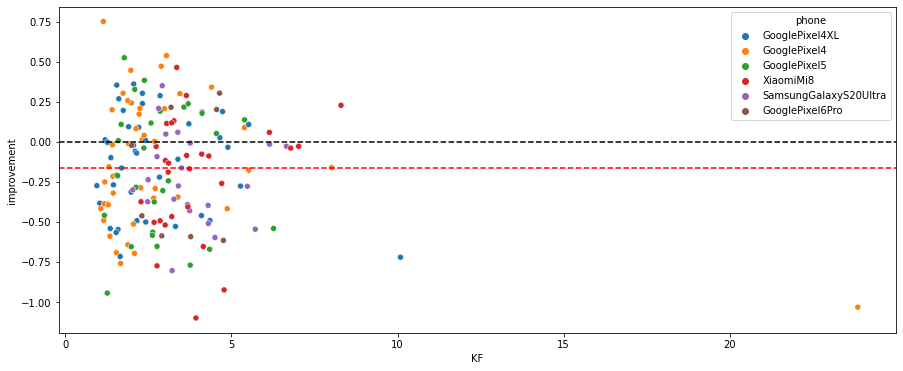

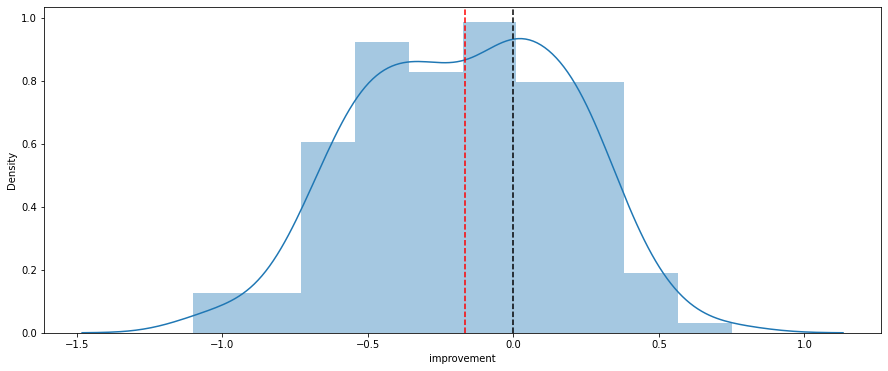

In [ ]:
results2 = results
results2.reset_index(drop=True)
results2['improvement'] = results2['KF'] - results2['NN']

plt.figure(1, figsize=(15,6))
sns.scatterplot('KF', 'improvement', data=results2, hue='phone')
plt.axhline(0, c= 'black', ls = '--')
plt.axhline(results2.improvement.mean(), c = 'red', ls = '--')

plt.figure(2, figsize=(15,6))
sns.distplot(results2.improvement)
plt.axvline(0, c= 'black', ls = '--')
plt.axvline(results2.improvement.mean(), c = 'red', ls = '--')

